#  Monte Carlo Control for Q Table and Optimal Policy


In [3]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Blackjack environment: [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py)

Each state is a tuple of 3 sub states:
- Player's current sum $\in \{0, 1, \ldots, 31\}$,
- Dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:
- STICK = 0
- HIT   = 1

In [4]:
# initialize environment
env = gym.make('Blackjack-v0')

In [5]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Constant-$\alpha$ Monte Carlo Control


Algorithm has following arguments:
- `env`: An instance of an OpenAI Gym environment.
- `num_episodes`: Number of episodes that are generated through agent-environment interaction.
- `alpha`: Step size parameter to control change in state-action value 
- `gamma`: The discount rate [0, 1]

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [6]:
def generate_episode(env, Q, epsilon):
    '''
    Generate episodes under given Q table
    '''
    episode = []
    
    # 0 -> player sum, 1- dealers face up card, 2- usable ace or not
    state = env.reset()
            
    while True:
        
        action = get_state_action(state, Q, epsilon, env.action_space.n)
                        
        next_state, reward, done, info = env.step(action)
        
        episode.append((state, action, reward))
        
        # update current state
        state = next_state
        
        if done:
            break
        
    return episode


def get_state_action(state, Q, epsilon, num_actions):
    '''
    Get the optimal action for given state using epsilon greedy policy
    '''
    
    # assign equal probabilities to each action
    probs = np.ones(num_actions) / num_actions
            
    if state in Q:
        
        # assign equal probabilities to each one
        probs *= epsilon
        
        # find the action with max state-action value
        optim_action = np.argmax(Q[state])
        
        # adjust the probabilities of optimal action
        probs[optim_action] = (1. - epsilon) + (epsilon / num_actions)
       
    return np.random.choice(np.arange(num_actions), p = probs)


def update_q_table(episode, Q, N, returns_sum, alpha, gamma=1.0):
    '''
    Update Q table for given episode
    '''
    
    # get states, actions and corresponding rewards for generated episode
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma ** i for i in range(len(states))])
    
    state_actions = list()
                
    for i, state in enumerate(states):
        
        action = actions[i]
        
        # First visit Monte Carlo
        if [state, action] not in state_actions:
            
            state_actions.append([state, action])
            
            # calculate discounted total reward from this state to terminal state
            reward = sum(rewards[i:] * discounts[:(len(discounts) - i)])
                                    
            N[state][action] += 1
            returns_sum[state][action] += reward
            
            state_action_value = returns_sum[state][action] / N[state][action]
        
            # update Q table
            Q[state][action] += alpha * (state_action_value - Q[state][action])
                       
                                                    
    return Q, N, returns_sum


def get_policy(Q):
    '''
    Generate the optimal policy from the Q table
    '''
    
    policy = dict()
    
    for state in Q:
        policy[state] = np.argmax(Q[state])
        
    return policy
        
    
def monte_carlo_control(env, num_episodes, alpha, gamma = 1.0,
                        epsilon = 1., epsilon_decay = 0.99999, epsilon_min = 0.05):
    '''
    Monte carlo control method to generate the optimal policy and Q table using exploration
    '''
    num_actions = env.action_space.n
    
    # set default Q table for state, action pair to 0
    Q = defaultdict(lambda: np.zeros(num_actions))
    N = defaultdict(lambda: np.zeros(num_actions))
    returns_sum = defaultdict(lambda: np.zeros(num_actions))
    
    # find the Q table by episode exploration
    for i_episode in range(1, num_episodes+1):
        
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        
        # generate episode
        episode = generate_episode(env, Q, epsilon)
        
        # update Q table
        Q, N, returns_sum = update_q_table(episode, Q, N, returns_sum, alpha, gamma)
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
    
    # retrieve the poliy from Q table
    policy = get_policy(Q)
    
    return policy, Q

In [8]:
# obtain the estimated optimal policy and action-value function
policy, Q = monte_carlo_control(env, num_episodes = 600000, alpha = 0.02, gamma = 1.0)

Episode 600000/600000.

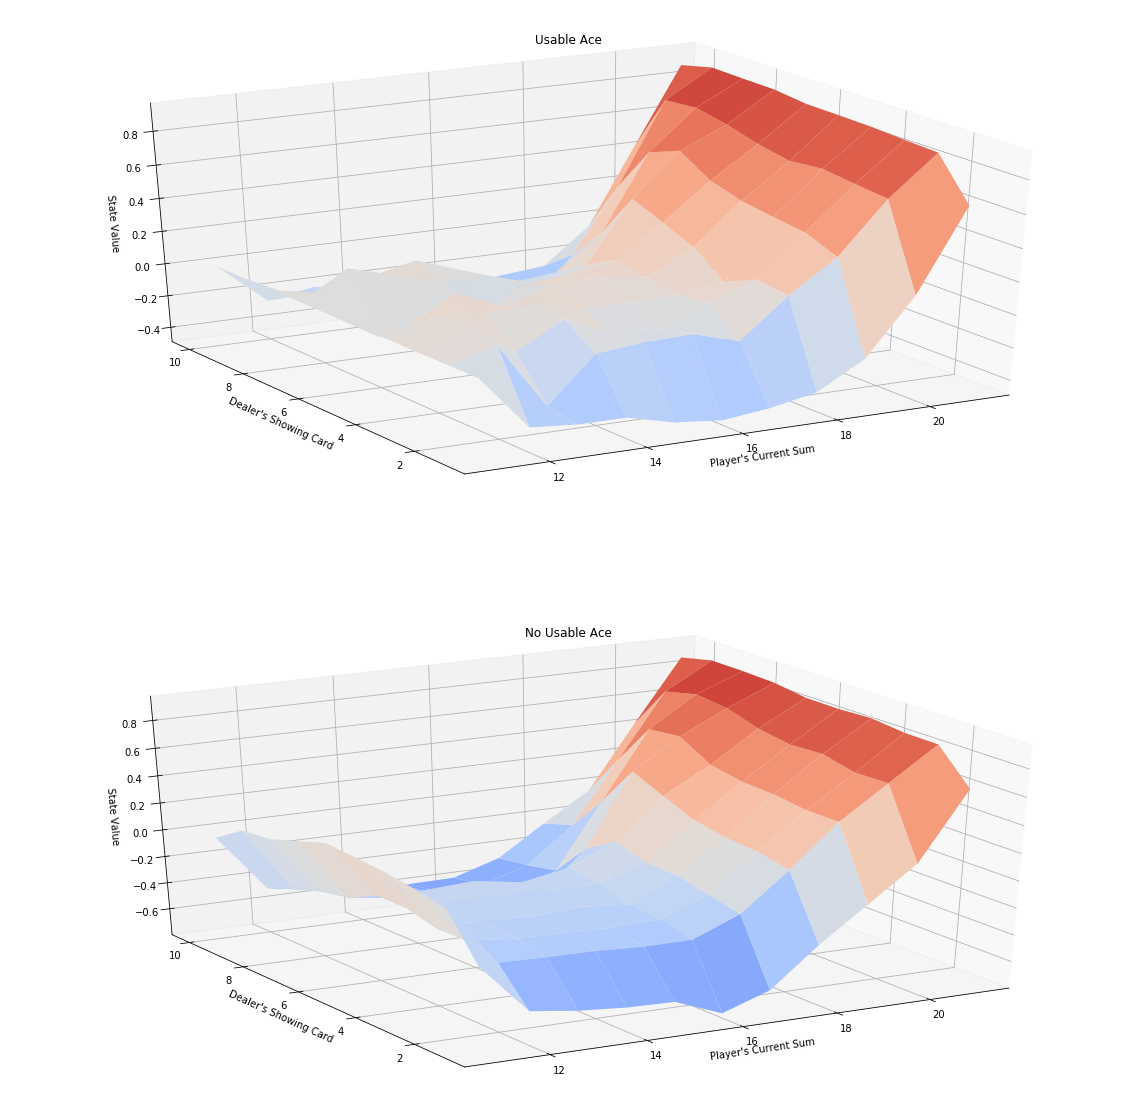

In [9]:
# get the state-value function from Q table
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

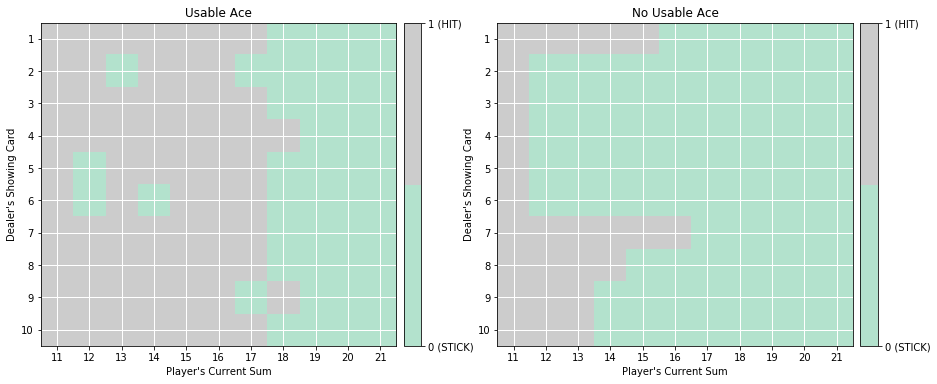

In [10]:
# plot the learned policy
plot_policy(policy)